## 5.14　应用：人脸识别管道
虽然本章介绍了许多机器学习的核心概念和算法，但是将这些概念应用到真实工作中还是有难度的。真实世界的数据集通常都充满噪音和杂质，有的可能是缺少特征，有的可能是数据形式很难转换成整齐的[n_samples, n_features] 特征矩阵。当你应用本章介绍的任何方法之前，都需要先从数据中提取特征。怎么提取特征这件事情并没有万灵药，只能靠数据科学家不断地磨炼直觉、积累经验。

机器学习中最有趣、也是最具挑战性的任务就是图像识别，前面也已经介绍过一些通过像素级特征进行分类学习的案例。在真实世界中，数据通常不会像数据集这么整齐，再用简单的像素特征就不合适了。也正因如此，有关图像数据特征提取方法的研究取得了大量成果（详情请参见5.4 节）。

在本节中，我们将介绍一种图像特征提取技术——**方向梯度直方图**（Histogram of Oriented Gradients，HOG，http://bit.ly/2fCEAcb ）。**它可以将图像像素转换成向量形式，与图像具体内容有关，与图像合成因素无关，如照度（illumination）**。我们将根据这些特征，使用前面介绍过的机器学习算法和内容开发一个简单的人脸识别管道。首先还是导入标准的程序库：

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

### 5.14.1　HOG特征
方向梯度直方图是一个简单的特征提取程序，**专门用来识别有行人（pedestrians）的图像内容**。HOG 方法包含以下五个步骤。
1. 图像标准化（可选），消除照度对图像的影响。
2. 用与水平和垂直方向的亮度梯度相关的两个过滤器处理图像，捕捉图像的边、角和纹理信息。
3. 将图像切割成预定义大小的图块，然后计算每个图块内梯度方向的频次直方图。
4. 对比每个图块与相邻图块的频次直方图，并做标准化处理，进一步消除照度对图像的影响。
5. 获得描述每个图块信息的一维特征向量。

Scikit-Image 项目内置了一个快速的HOG 提取器，可以用它快速获取并可视化每个图块的方向梯度（如图5-149 所示）：

D:\Python\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


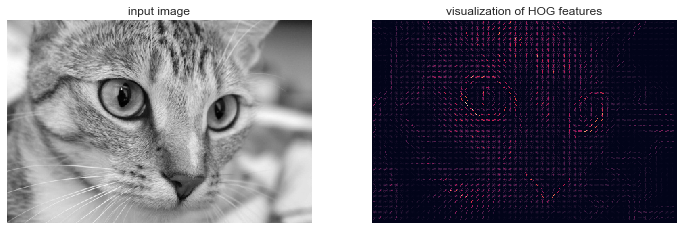

In [2]:
from skimage import data, color, feature
import skimage.data

image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualise=True, block_norm`==`L1)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

### 5.14.2　HOG实战：简单人脸识别器
有了图像的HOG 特征后，就可以用Scikit-Learn 的任意评估器建立一个简单人脸识别算法，这里使用线性支持向量机（详情请参见5.7 节），具体步骤如下。
1. 获取一组人脸图像缩略图，构建“正”（positive）训练样本。
2. 获取另一组人脸图像缩略图，构建“负”（negative）训练样本。
3. 提取训练样本的HOG 特征。
4. 对样本训练一个线性SVM 模型。
5. 为“未知”图像传递一个移动的窗口，用模型评估窗口中的内容是否是人脸。
6. 如果发现和已知图像重叠，就将它们组合成一个窗口。

下面一步一步来实现。
#### (1) 获取一组正训练样本。
首先找一些能体现人脸变化的图像作为正训练样本。获取这些图像的方法很简单——Wild 数据集里面带标签的人脸图像就是，用Scikit-Learn 可以直接下载：

In [ ]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

这样就可以获得用于训练的13 000 张照片了。

#### (2) 获取一组负训练样本。
之后需要获取一组近似大小的缩略图，但它们不在训练样本中。解决这个问题的一种方法是引入别的图像语料库，然后再按需求抽取缩略图。这里使用Scikit-Image 的图像数据，再用Scikit-Image 的PatchExtractor 提取缩略图：

In [ ]:
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

In [ ]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0,
                    patch_size=positive_patches[0].shape):
    extracted_patch_size = \
    tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

现在就有了30 000 张尺寸合适、未经识别的图像。先来看一些图像，直观感受一下（如图5-150 所示）：

In [ ]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

我们希望这些图像可以让我们的算法学会“没有人脸”是什么样子。

#### (3) 组合数据集并提取HOG 特征。
现在就有了正样本和负样本。将它们组合起来，然后计算HOG 特征。这些步骤需要耗点儿时间，因为对每张图象进行HOG 特征提取的计算量可不小：

In [ ]:
from itertools import chain
    X_train = np.array([feature.hog(im)
                        for im in chain(positive_patches,
                                        negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [ ]:
X_train.shape

这样，我们就获得了43 000 个训练样本，每个样本有1215 个特征。现在有了特征矩阵，就可以给Scikit-Learn 训练了。

#### (4) 训练一个支持向量机。
下面用本章介绍过的工具来创建一个缩略图分类器。**对于高维度的二元分类（是不是人脸）任务，用线性支持向量机是个不错的选择**。
<br>这里用Scikit-Learn 的LinearSVC，因为它比SVC 更适合处理大样本数据。

首先，用简单的高斯朴素贝叶斯分类器算一个初始解：

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

我们发现，对于训练数据，即使用简单的朴素贝叶斯算法也可以获得90% 以上的准确率。现在再用支持向量机分类，用网格搜索获取最优的边界软化参数C：

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV

grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

In [ ]:
grid.best_params_

用最优的评估器重新训练数据集：

In [ ]:
model = grid.best_estimator_
model.fit(X_train, y_train)

#### (5) 在新图像中寻找人脸。
模型已经训练完成，让我们拿一张新图像检验模型的训练效果。使用一张宇航员照片的局部图像（详情请参见5.14.3 节），在上面运行一个移动窗口来评估每次移动的结果（如图5-151 所示）：

In [ ]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

然后，创建一个不断在图像中移动的窗口，然后计算每次移动位置的HOG 特征：

In [ ]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

最后，收集这些HOG 特征，并用训练好的模型来评估每个窗口中是否有人脸：

In [ ]:
labels = model.predict(patches_hog)
labels.sum()

在近2000 幅图像中，总共发现了33 幅带人脸的图像。用矩形把收集到的信息画在图像上（如图5-152 所示）：

In [ ]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2,
                               facecolor='none'))

所有窗口都重叠在一起，并找到了图像中的人脸！简单的几行Python 代码就有着巨大的威力。

### 5.14.3　注意事项与改进方案
如果你继续研究前面的代码和示例，就会发现在发布一个产品级的人脸识别器之前，还有一些工作要做。有些问题已经解决了，但还有一些内容有待完善。

* 我们的训练集，尤其是负样本特征（negative feature）并不完整
    * 这个问题的关键在于，有许多类似人脸的纹理并不在训练集里面，因此我们的模型非常容易产生假正错误（false positives）。如果你用前面的算法评估完整的宇航员照片就可能会出错：模型可能会将图像的其他地方误判为人脸。如果引入更多的负训练集图像，应该可以改善这个问题。另一种改善方案是用更直接的方法，例如困难负样本挖掘（hard negative mining）。在困难负样本挖掘方法中，给分类器看一些没见过的新图像，找出所有分类器识别错误的假正图像，然后将这些图像增加到训练集中，再重新训练分类器。
* 目前的管道只搜索一个尺寸
    * 我们的算法会丢失一些尺寸不是62 像素× 47 像素的人脸。我们可以采用不同尺寸的窗口来解决这个问题，每次将图形提供给模型之前，都用skimage.transform.resize 重置图像尺寸——其实前面使用的sliding_window() 函数已经具备这种功能。
* 应该将包含人脸的重叠窗口合并
    * 一个产品级的管道不应该让同一张脸重复出现30 次，而是将这些重叠的窗口合并成一个。这个问题可以通过一个无监督的聚类方法（MeanShift 聚类就是解决这个问题的好办法）来解决，或者通过机器视觉常用的算法，例如非极大值抑制（nonmaximum suppression）来解决。
* 管道可以更具流线型
    * 一旦解决了以上问题，就可以创建一个更具流线型的管道，将获取训练图像和预测滑动窗口输出的功能都封装在管道中，那样效果会更好。这正体现了Python 作为一个数据科学工具的优势：只要花一点儿功夫，就可以完成原型代码，并将其打包成设计优良的面向对象API，让用户可以轻松地使用它们。我觉得这条建议可以作为“读者练习”，感兴趣的读者可以试试。
* 应该考虑使用更新的技术，例如深度学习
    * 不得不说，HOG 和其他图像特征提取方法已经不是最新的技术了。许多流行的物体识别管道都在使用各种深度神经网络（deep neural network）。你可以将神经网络看成一种评估器，具有自我学习的能力，可以从数据中确定最优特征提取策略，而不需要依赖用户的直觉。虽然有关深度神经网络方法的内容（以及计算量）超出了本节涵盖的范围，但是开源工具（如谷歌的TensorFlow，https://www.tensorflow.org/ ）已经让深度学习方法不再那么高高在上。在我写这本书的时候，由于Python 的深度学习还不太成熟，因此还不能推荐学习资源，不过下一节介绍的参考资料非常适合机器学习新手入门。